In [1]:
# in case there are any problems with importing because path is wrong
import sys
sys.path.append('/Users/daniel/Library/CloudStorage/Box-Box/Research/discrete_sr/code/SPIDER_discrete/src')

import os
# Suppress OpenMP deprecation warning from numba (using latest stable numba 0.61.2)
# This is a known issue with OpenMP 5.0+ and is the recommended workaround
os.environ['KMP_WARNINGS'] = '0'

In [2]:
import numpy as np

from PySPIDER.commons.weight import *
from PySPIDER.commons.utils import save, load
from PySPIDER.discrete.library import *
from PySPIDER.discrete.process_library_terms import *

# load memory profiler
%load_ext memory_profiler

In [3]:
from scipy import ndimage
from scipy.signal import windows

# Tunable window size for smoothing
sigma = 40 # 400  # Adjust this parameter to control smoothing strength

def smooth_along_time_axis(data, sigma):
    """
    Apply Gaussian smoothing along the time axis (axis 2) of the data.
    
    Parameters:
    - data: array with shape (particles, spatial_dims, time_steps)
    - sigma: std. dev of the Gaussian smoothing window
    
    Returns:
    - smoothed_data: same shape as input, smoothed along time axis
    """
    # Create a 1D Gaussian window that goes to zero at edges
    window_size = sigma * 6 # Standard deviation for Gaussian
    gaussian_window = windows.gaussian(window_size, sigma)
    gaussian_window = gaussian_window / np.sum(gaussian_window)  # Normalize
    
    # Apply 1D convolution along the time axis (axis=2) for each particle and spatial dimension
    smoothed_data = np.zeros_like(data)
    
    for particle in range(data.shape[0]):
        for spatial_dim in range(data.shape[1]):
            # Apply 1D convolution with 'same' mode to preserve time series length
            smoothed_data[particle, spatial_dim, :] = np.convolve(
                data[particle, spatial_dim, :], 
                gaussian_window, 
                mode='same'
            )
    
    return smoothed_data

# Alternative implementation using scipy.ndimage for potentially better performance
def smooth_along_time_axis_ndimage(data, sigma):
    """
    Alternative implementation using scipy.ndimage.gaussian_filter1d
    """
    #window_size = sigma * 6.0  # Convert window size to sigma for Gaussian
    
    # Apply Gaussian filter along axis 2 (time axis)
    smoothed_data = ndimage.gaussian_filter1d(data, sigma=sigma, axis=2, mode='nearest')
    
    return smoothed_data


In [4]:
#data = np.load('LJ/positions_rho_0.30.npz')
#data = np.load('LJ/positions_rho_0.30_savefreq_5.npz')
data = np.load('LJ/positions_rho_0.30_savefreq_3.npz')

positions_orig = data['positions'] 
vs_orig = data['vs']
deltat = data['deltat']
dims = data['dims']

del data

print(positions_orig.shape, vs_orig.shape, deltat, dims)

Np, nt = positions_orig.shape[0], positions_orig.shape[2]
world_size = np.array([dims[0], dims[1], nt])


(9600, 2, 10000) (9600, 2, 10000) 2.539543411945013 [248.66604111 248.66604111]


In [5]:
smooth_trajectories = True
edit_positions = False

if smooth_trajectories:
    # Apply smoothing ONLY to velocities to avoid periodic boundary artifacts
    print(f"Applying Gaussian smoothing to velocities with sigma {sigma}...")
    print(f"Original shapes - positions: {positions_orig.shape}, vs: {vs_orig.shape}")

    # Smooth only the velocities
    vbar = smooth_along_time_axis_ndimage(vs_orig, sigma)
    vprime = vs_orig - vbar

    # Compute positions by integrating smoothed velocities with periodic boundaries
    def integrate_velocities_periodic(initial_positions, velocities, dt, domain_size):
        """
        Integrate velocities to get positions with periodic boundary conditions.
        
        Parameters:
        - initial_positions: starting positions at t=0, shape (particles, spatial_dims)
        - velocities: velocity time series, shape (particles, spatial_dims, time_steps)
        - dt: time step
        - domain_size: size of periodic domain [Lx, Ly]
        
        Returns:
        - positions: integrated positions with periodic wrapping
        """
        positions = np.zeros_like(velocities)
        positions[:, :, 0] = initial_positions
        
        for t in range(1, velocities.shape[2]):
            # Integrate: x(t+dt) = x(t) + v(t) * dt
            positions[:, :, t] = positions[:, :, t-1] + velocities[:, :, t-1] * dt
            
            # Apply periodic boundary conditions
            for dim in range(2):  # x and y dimensions
                # Wrap positions that exceed domain boundaries
                positions[:, dim, t] = np.mod(positions[:, dim, t], domain_size[dim])
        
        return positions

    if edit_positions:
        print("Computing positions by integrating smoothed velocities...")
        positions = integrate_velocities_periodic(
            initial_positions=positions_orig[:, :, 0], 
            velocities=vs, 
            dt=deltat, 
            domain_size=dims
        )
    else:
        positions = positions_orig

    del positions_orig, vs_orig

else: # do no smoothing
  positions = positions_orig
  vs = vs_orig


# subsampling
subsample_factor = 10
positions = positions[:, :, ::subsample_factor]
if smooth_trajectories:
    vprime = vprime[:, :, ::subsample_factor]
    vbar = vbar[:, :, ::subsample_factor]
else:
    vs = vs[:, :, ::subsample_factor]
deltat *= subsample_factor
nt /= subsample_factor
world_size[2] = nt

if smooth_trajectories:
    print(f"Final shapes - positions: {positions.shape}, vprime: {vprime.shape}, vbar: {vbar.shape}")
else:
    print(f"Final shapes - positions: {positions.shape}, vs: {vs.shape}")
print(deltat, dims)

Applying Gaussian smoothing to velocities with sigma 40...
Original shapes - positions: (9600, 2, 10000), vs: (9600, 2, 10000)
Final shapes - positions: (9600, 2, 1000), vprime: (9600, 2, 1000), vbar: (9600, 2, 1000)
25.39543411945013 [248.66604111 248.66604111]


In [6]:
plot = False
if plot:
    import matplotlib.pyplot as plt
    from matplotlib import animation
    from matplotlib.animation import FuncAnimation
    from IPython.display import HTML
    plt.rcParams['animation.ffmpeg_path'] = '/Users/daniel/Documents/ffmpeg-7.1/ffmpeg'

    vid_file = 'LJ/n9600rho0_30_sf3_smoothed.mp4'

    fig, ax = plt.subplots(figsize=(6, 6))
    qv = ax.quiver(positions[:, 0, -1], positions[:, 1, -1], 1, 0, clim=[-np.pi, np.pi])

    def animate(i):
        if i % 10 == 0:
            print(i)
        qv.set_offsets(positions[:, :, i])
        norms = np.sqrt(vs[:, 0, i] ** 2 + vs[:, 1, i] ** 2)
        qv.set_UVC(vs[:, 0, i] / norms, vs[:, 1, i] / norms, np.angle(vs[:, 0, i] + 1.0j * vs[:, 1, i]))
        return qv,

    anim = FuncAnimation(fig, animate, np.arange(0, positions.shape[-1]), interval=1, blit=True)
    FFwriter = animation.FFMpegWriter(fps=24, codec="libx264")
    anim.save(vid_file, writer=FFwriter, dpi=100)

In [7]:
smooth_cg_fields = not smooth_trajectories

data_dict = {}
if not smooth_trajectories:
    data_dict['v'] = vs
    v_obs = Observable(string='v', rank=1)
    observables = [v_obs]
else:
    data_dict['vbar'] = vbar
    data_dict['v\''] = vprime
    vbar_obs = Observable(string='vbar', rank=1)
    vprime_obs = Observable(string='v\'', rank=1)
    observables = [vbar_obs, vprime_obs]

# fix random seed
np.random.seed(1)

# initial setup of dataset
corr_L = 20 #0.2
corr_T = 500
kernel_sigma = 3 # 4
if smooth_cg_fields:
    t_sigma = 40
else:
    t_sigma = 0
cg_res = 1
srd = SRDataset(world_size=world_size, data_dict=data_dict, particle_pos=positions, observables=observables, 
rho_scale=Np/dims[0]/dims[1], irreps=SRDataset.all_rank2_irreps(), kernel_sigma=kernel_sigma, 
time_sigma=t_sigma, cg_res=cg_res, deltat=deltat, cutoff=6, wrap=True)
#v_est = np.mean(np.abs(vs))*2**0.5
#print(v_est)

# initialize libraries, domains, and weights
#srd.make_libraries(max_complexity=4, max_rho=2)
srd.make_libraries(max_complexity=5, max_rho=2)
#srd.make_libraries(max_complexity=6, max_rho=2)
for irrep in srd.irreps:
    print(irrep, ":", len(srd.libs[irrep].terms))

dom_width = 30 # 0.1
dom_time = 200  # 30

Rank 0 : 81
Rank 1 : 113
Antisymmetric rank 2 : 45
Symmetric trace-free rank 2 : 81


In [ ]:
%%prun # compute time profiling
#%%memit # memory profiling - doesn't work in VSCode or clones thereof for whatever reason.

srd.make_domains(ndomains=30, domain_size=[dom_width, dom_width, dom_time], t_pad=t_sigma*3)
#srd.make_domains(ndomains=60, domain_size=[dom_width, dom_width, dom_time])
#srd.make_domains(ndomains=100, domain_size=[dom_width, dom_width, dom_time])
srd.make_weights(m=8, qmax=1)
#srd.set_LT_scale(L=corr_L, T=corr_L/v_est) # note that this line must go before make_library_matrices
srd.set_LT_scale(L=corr_L, T=corr_T) # note that this line must go before make_library_matrices
srd.make_library_matrices(debug=False) #debug=False

In [ ]:
from scipy.stats._stats import gaussian_kernel_estimate
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML

def coarse_grain_slice(t, sigma, field='rho', component=None):
    pt_pos = positions[:, :, t]
    weights = np.ones(pt_pos.shape[0], dtype=np.float64)
    if field == 'v':
        weights *= vs[:, component, t]
    xx, yy = np.meshgrid(range(int(dims[0])), range(int(dims[1])))
    xi = np.vstack([xx.ravel(), yy.ravel()]).T

    sigma_sq = sigma ** 2
    # Check scipy version. If it's lower than 1.10, use inverse_covariance, otherwise use Cholesky
    if int(scipy.__version__.split(".")[0]) <= 1 and int(scipy.__version__.split(".")[1]) < 10:
        inv_cov = np.eye(2) / sigma_sq
    else:
        inv_cov = np.eye(2) * sigma_sq
        inv_cov = np.linalg.cholesky(inv_cov[::-1, ::-1]).T[::-1, ::-1]
    density = gaussian_kernel_estimate['double'](pt_pos, weights[:, None], xi, inv_cov,
                                                 np.float64)
    output = np.reshape(density[:, 0], xx.shape)
    return output

t = 300
sigma = kernel_sigma
rho_cg = coarse_grain_slice(t, sigma, field='rho')
vx_cg = coarse_grain_slice(t, sigma, field='v', component=0)
vy_cg = coarse_grain_slice(t, sigma, field='v', component=1)

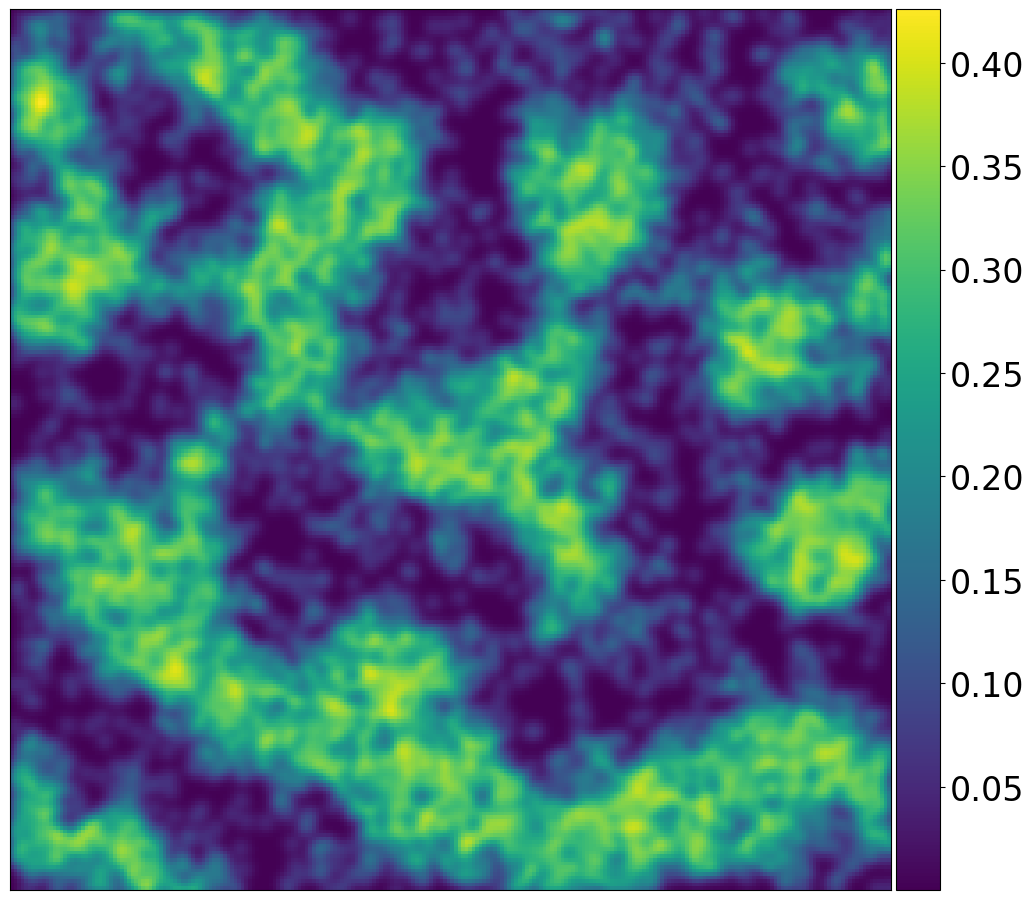

In [ ]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 12))
im1 = ax1.imshow(rho_cg)

frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
#colorbar
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cb1 = plt.colorbar(im1, cax=cax1)
cb1.ax.tick_params(labelsize=24) 

name = f'cg_rho_{sigma}.eps'
plt.savefig(name, bbox_inches='tight', format='eps') # dpi=300,

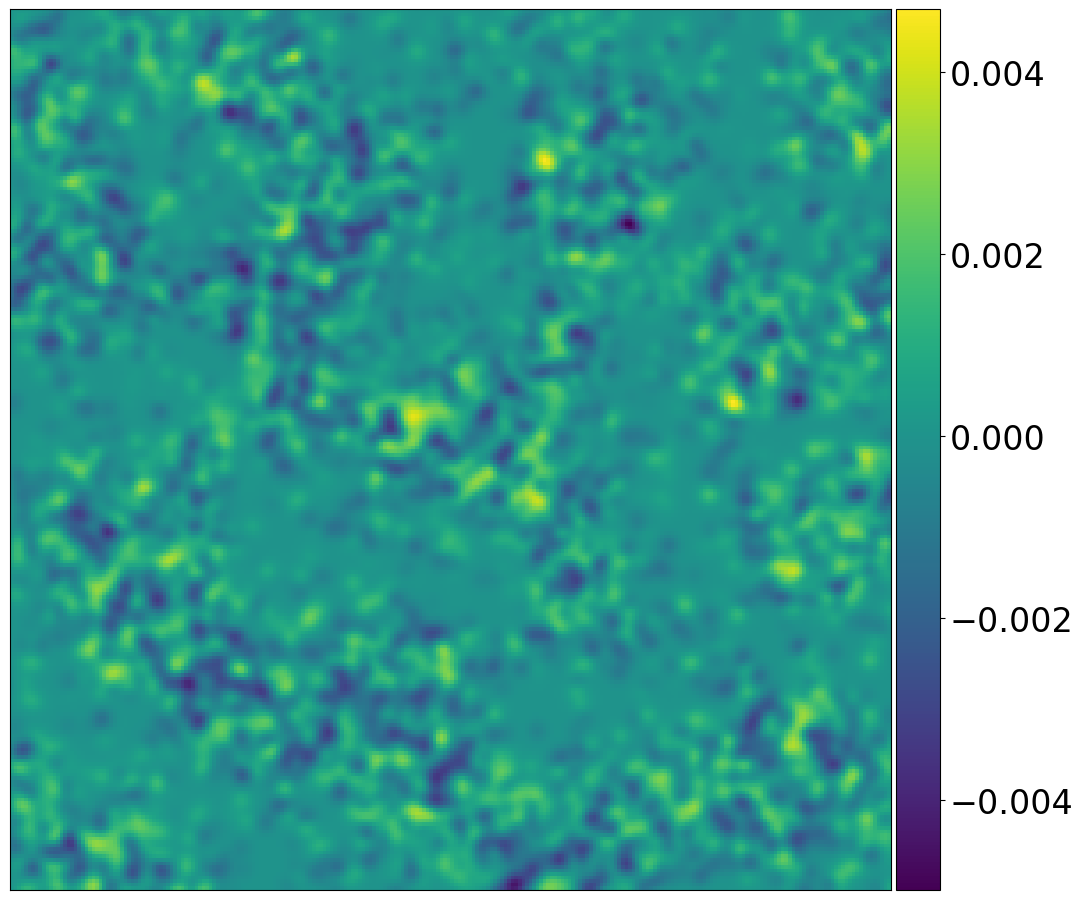

In [ ]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 12))
im1 = ax1.imshow(vx_cg)

frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
#colorbar
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cb1 = plt.colorbar(im1, cax=cax1)
cb1.ax.tick_params(labelsize=24) 

name = f'cg_vx_{sigma}.eps'
plt.savefig(name, bbox_inches='tight', format='eps') # dpi=300,

In [ ]:
from PySPIDER.commons.identify_models import interleave_identify
from PySPIDER.commons.sparse_reg_bf import Scaler, Initializer, ModelIterator, Residual, Threshold


libs = srd.libs

reg_opts_list = []
for irrep in srd.irreps:
    #print(np.linalg.norm(libs[irrep].Q, axis=0))
    # for regression we now need to construct a Scaler, Initializer, ModelIterator, and Threshold
    scaler = Scaler(sub_inds=None, char_sizes=libs[irrep].col_weights, row_norms=None, unit_rows=True, train_fraction=1)
    init = Initializer(method='combinatorial', start_k=3)
    #init = Initializer(method='combinatorial', start_k=9999)
    #init = Initializer(method='power', start_k=10)
    #res = Residual(residual_type='fixed_column', anchor_col=0)
    #res = Residual(residual_type='dominant_balance')
    #res = Residual(residual_type='matrix_relative')
    res = Residual(residual_type='hybrid')
    
    iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=3)
    #iterator = ModelIterator(max_k=len(libs[irrep].terms), backward_forward=False, max_passes=1)
    thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
    #thres = Threshold(threshold_type='information', ic=AIC)
    
    opts = {'scaler': scaler, 'initializer': init, 'residual': res,
            'model_iterator': iterator, 'threshold': thres}
    opts['verbose'] = False
    opts['inhomog'] = False
    opts['inhomog_col'] = None
    reg_opts_list.append(opts)


eqs, lambdas, reg_results, derived_eqs, excluded_terms = interleave_identify([libs[i] for i in srd.irreps], 
    #reg_opts_list, threshold=1e-6, experimental=True, report_accuracy=True,
    reg_opts_list, threshold=5e-2, experimental=True, report_accuracy=True, max_equations=99,
    #print_opts={'num_format': '{0:.3g}', 'latex_output': True}
)

--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 3 ---
[0.02 s]
Identified model: ∂t ρ + 0.987 · ∂α ρ[v'_α] + 0.998 · ∂α ρ[vbar_α] = 0 (order 3, residual 4.15e-03)
(r_h = 4.15e-03)
[0.38 s]
Identified model: ρ[v'_α · vbar_α] = 0 (order 3, residual 4.86e-02)
[0.52 s]
Identified model: -0.000526 · ρ + ρ[v'_α · v'_α] = 0 (order 3, residual 2.87e-02)
(r_h = 2.87e-02)
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 3 ---
--- WORKI

KeyboardInterrupt: 

[0.005 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
(np.float64(0.9932290104975142), np.float64(1.0))
[∂t² ρ]
0.993 · ∂t² ρ + ∂t ∂α ρ[v_α] = 0


/var/folders/p_/dc9h9qcj62qgv461rz72zx_80000gn/T/ipykernel_39876/2953716743.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


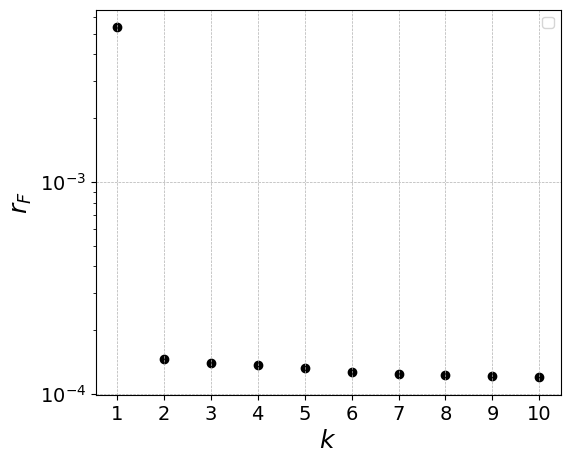

[7.535e-03 5.825e-04 5.436e-04 1.403e-04 1.276e-04 1.159e-04 1.078e-04
 1.029e-04 9.549e-05 8.965e-05]
(np.float64(-0.5437706562004786), np.float64(-0.5627782246689902), np.float64(0.9731046014364088), np.float64(1.0))
[∂t ρ, ∂α ρ[v_α]]
-0.544 · ρ · ∂t ρ + -0.563 · ρ · ∂α ρ[v_α] + 0.973 · ∂t ρ + ∂α ρ[v_α] = 0


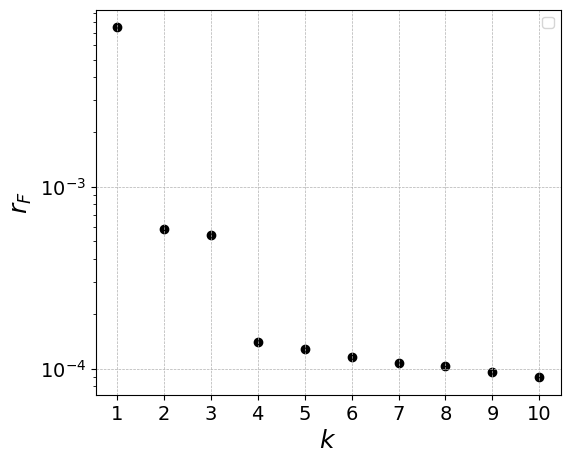

[1.900e-04 7.310e-06 6.517e-06 6.258e-06 5.951e-06 5.570e-06 5.499e-06
 5.389e-06 5.302e-06 5.214e-06]
(np.float64(1.0), np.float64(0.9912255556584517))
[ρ · ∂t³ ρ, ∂t ρ · ∂t ρ, ∂t ρ · ∂α ρ[v_α]]
∂t ρ · ∂t ρ + 0.991 · ∂t ρ · ∂α ρ[v_α] = 0


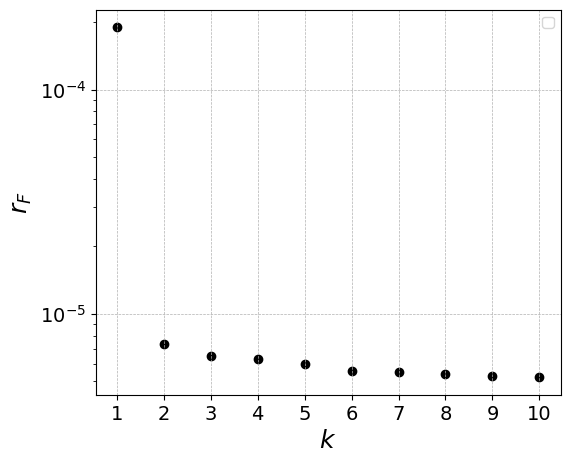

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
for i, res in enumerate(reg_results):
    if len(eqs[i].terms)>1:
        all_lambdas = res.all_lambdas
        print(all_lambdas)
        all_xis = res.all_xis
        xi_values = res.xi
        sublibrary_terms = res.sublibrary
        equations = []
        print(eqs[i].coeffs)
        print([t for (t, c) in zip(res.sublibrary, res.all_xis[i]) if c!=0])
        #equation_terms = [f"{xi:.1e} {term}" for xi, term in zip(xi_values, sublibrary_terms) if abs(xi) > 1e-15]
        #equation_string = " + ".join(equation_terms)
        equation_string = str(eqs[i].pstr(**{'num_format': '{0:.3g}', 'latex_output': False}))
        print(equation_string)
    
        
        plt.figure(figsize=(6, 5))
        #plt.scatter(range(2, len(all_lambdas) + 1), all_lambdas[1:], color='k')#, label="Lambda values") # range(1, 
        max_terms = min(10, len(all_lambdas))
        plt.scatter(range(1, max_terms+1), all_lambdas[:10], color='k')#, label="Lambda values")

        
        # Set log scale for y-axis
        plt.yscale("log")

        fs = 18
        fs2 = 14
        plt.xlabel("$k$", fontsize=fs)
        plt.ylabel("$r_F$", fontsize=fs)
        #plt.title(f"Equation: {equation_string}")  # Use the computed equation as the title
        #plt.xticks(range(2, len(all_lambdas) + 1), fontsize=fs2)  # Ensure x-axis ticks match the number of equations
        plt.xticks(range(1, max_terms+1), fontsize=fs2)  # Ensure x-axis ticks match the number of equations

        plt.yticks(fontsize=fs2)
        plt.legend()
        plt.grid(True, linestyle="--", linewidth=0.5) # which="both"

        name = f'discrete_pareto_{i}.eps'
        #plt.savefig(name, bbox_inches='tight', format='eps') # dpi=300, 
        plt.show()

In [ ]:
print(srd.scale_dict)
for irrep in srd.irreps:
    # don't forget preprocessing
    Q = srd.libs[irrep].Q/srd.libs[irrep].col_weights # reweight columns
    for i in range(Q.shape[0]): # normalize rows
        Q[i, :] /= np.linalg.norm(Q[i, :])
    [U, S, V] = np.linalg.svd(Q)
    print(np.linalg.norm(Q)/max(S))

{'v': {'mean': np.float64(0.01644155390782384), 'std': np.float64(0.016441553907823828)}, 'rho': {'mean': np.float64(1.0), 'std': np.float64(0.4748140911656666)}}
1.0263767172693707
1.3385510279282717
1.0317468848515952
1.0790547880910348


In [ ]:
lib0 = libs[srd.irreps[0]]
for i, term, size in zip(list(range(len(lib0.terms))), lib0.terms, lib0.col_weights):
    print(i, term, size, np.linalg.norm(lib0.Q[:, i])/size, term.complexity)
print(next(regex_find(lib0.terms, r'∂t ρ')))
print(next(regex_find(lib0.terms, r'∂α ρ\[v_α\]')))

0 ρ 1.0 32753.143148954736 1
1 ρ · ρ 1.0 58785.43049438995 2
2 ρ · ∂α² ρ 0.0011870352279141664 199634.48130337454 4
3 ρ · ∂t ρ 0.0009496281823313332 2532.8779176310113 3
4 ρ · ∂t ∂α² ρ 2.374070455828333e-06 42080.07099698468 5
5 ρ · ∂t² ρ 1.8992563646626663e-06 690.581971838838 4
6 ρ · ∂t³ ρ 3.798512729325333e-09 478.58306663721055 5
7 ρ · ∂α ρ[v_α] 0.00039033407380473424 6179.155213048606 4
8 ρ · ∂t ∂α ρ[v_α] 7.806681476094684e-07 1661.9941260830226 5
9 ρ · ρ[v_α · v_α] 0.00027032469490387745 118071.12990504404 4
10 ρ · ∂t ρ[v_α · v_α] 2.5670794866084086e-07 4810.401904165668 5
11 ∂α ρ · ∂α ρ 0.0005636210529236949 381846.31591235293 4
12 ∂α ρ · ∂t ∂α ρ 1.1272421058473897e-06 17806.503321646294 5
13 ∂α ρ · ρ[v_α] 0.00039033407380473456 6143.831047180731 4
14 ∂α ρ · ∂t ρ[v_α] 3.7067223700917425e-07 3295.1941181829716 5
15 ∂α² ρ 0.0011870352279141664 151246.19762819234 3
16 ∂α² ρ · ∂t ρ 1.1272421058473895e-06 15586.047072167803 5
17 ∂α² ∂β² ρ 2.967588069785416e-06 6927388.087000861 5
18 

In [ ]:
lib1 = libs[srd.irreps[1]]
for i, term, size in zip(list(range(len(lib1.terms))), lib1.terms, lib1.col_weights):
    print(i, term, size, np.linalg.norm(lib1.Q[:, i])/size, term.complexity)
# print(next(regex_find(lib1.terms, r'∂α ∂β² ρ')))
print(next(regex_find(lib1.terms, r'∂t ρ\[vbar_α\]')))
print(next(regex_find(lib1.terms, r'∂β ρ\[v_α · v_β\]')))
print(next(regex_find(lib1.terms, r'∂t ρ\[v_α · v_β · v_β\]')))
print(next(regex_find(lib1.terms, r'∂t³ ρ\[v_α\]'))) 
print(next(regex_find(lib1.terms, r'ρ · ∂t ρ\[v_α\]'))) 
#print(next(regex_find(lib1.terms, r'∂t ρ\[v_α\] · ρ\[v_β · v_β\]')))
# print(next(regex_find(lib1.terms, r'∂α ρ\[v_β · v_β\]')))
# print(next(regex_find(lib1.terms, r'∂α ρ')))

0 ρ · ∂α ρ 0.025654039215467207 72194.4191195153 3
1 ρ · ∂α ∂β² ρ 6.413509803866801e-05 1085528.48858947 5
2 ρ · ∂t ∂α ρ 5.130807843093441e-05 15479.830803667839 4
3 ρ · ∂t² ∂α ρ 1.0261615686186883e-07 16837.730328574162 5
4 ρ · ρ[v'_α] 0.01580797085010366 2154.7256690558984 3
5 ρ · ∂β² ρ[v'_α] 2.0276915205276114e-05 125044.68094106168 5
6 ρ · ∂α ∂β ρ[v'_β] 2.0276915205276114e-05 38956.5846206541 5
7 ρ · ∂t ρ[v'_α] 1.622153216422089e-05 3099.26541525719 4
8 ρ · ∂t² ρ[v'_α] 3.244306432844178e-08 13170.14841825086 5
9 ρ · ∂β ρ[v'_α · v'_β] 6.4107376899005766e-06 75850.29116037485 5
10 ρ · ∂α ρ[v'_β · v'_β] 6.4107376899005766e-06 155208.07019612787 5
11 ρ · ρ[v'_α · v'_β · v'_β] 3.950284541099051e-06 9306.07055757 5
12 ρ · ρ[vbar_α] 0.003909871091156231 20186.890257619812 3
13 ρ · ∂β² ρ[vbar_α] 5.015199314997179e-06 398689.76942428114 5
14 ρ · ∂α ∂β ρ[vbar_β] 5.015199314997179e-06 141775.84023814587 5
15 ρ · ∂t ρ[vbar_α] 4.012159451997744e-06 9534.521959567739 4
16 ρ · ∂t² ρ[vbar_α] 8.024

StopIteration: 

In [ ]:
col_norms = np.linalg.norm(lib0.Q/lib0.col_weights, axis=0)
print(len(col_norms), lib0.Q.shape)
for term, norm in zip(lib0.terms, col_norms/max(col_norms)):
    print(term, norm)

101 (480, 101)
ρ 0.002056005956887021
ρ · ρ 0.003541990617156954
ρ · ∂α² ρ 0.015810327241602484
ρ · ∂α² ∂β² ρ 0.49543940933831604
ρ · ∂t ρ 0.0008287347597277464
ρ · ∂t ∂α² ρ 0.02055056057035392
ρ · ∂t² ρ 0.002480179134918307
ρ · ∂t² ∂α² ρ 0.08217491290496805
ρ · ∂t³ ρ 0.02425640867912395
ρ · ∂t⁴ ρ 0.19152101603379793
ρ · ∂α ρ[v_α] 0.002018852074263237
ρ · ∂α² ∂β ρ[v_β] 0.04994194935602318
ρ · ∂t ∂α ρ[v_α] 0.006064385026719698
ρ · ∂t² ∂α ρ[v_α] 0.05904274206545437
ρ · ρ[v_α · v_α] 0.006898330680319665
ρ · ∂α² ρ[v_β · v_β] 0.028855070047073092
ρ · ∂α ∂β ρ[v_α · v_β] 0.013934868454949139
ρ · ∂t ρ[v_α · v_α] 0.004522506818483578
ρ · ∂t² ρ[v_α · v_α] 0.02525900794894697
ρ · ∂α ρ[v_α · v_β · v_β] 0.008767893537668412
ρ · ρ[v_α · v_α · v_β · v_β] 0.027311962387167238
∂α ρ · ∂α ρ 0.024337606840789474
∂α ρ · ∂α ∂β² ρ 0.3998856429245233
∂α ρ · ∂t ∂α ρ 0.0049142831449809615
∂α ρ · ∂t² ∂α ρ 0.06388382693213407
∂α ρ · ρ[v_α] 0.0006679359437423121
∂α ρ · ∂α ∂β ρ[v_β] 0.011910606677788234
∂α ρ · ∂β² 

In [ ]:
lt = lib0.terms
print(f'{lt[15]}, {lt[25]}')
scaler = Scaler(sub_inds=[15, 25], char_sizes=lib0.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
rh, xi = hybrid_residual(lib0.Q, None, scaler, return_xi=True)
print(rh, xi)

∂α² ρ, ∂t² ρ
0.013713712920618243 [-4.793e-06  1.000e+00]


In [ ]:
lt = lib0.terms
print(f'{lt[15]}, {lt[25]}')
scaler = Scaler(sub_inds=[15, 25], char_sizes=lib0.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
rh, xi = hybrid_residual(lib0.Q, None, scaler, return_xi=True)
print(rh, xi)

∂α² ρ, ∂t² ρ
0.013713712920618243 [-4.793e-06  1.000e+00]


In [ ]:
lt = lib0.terms
print(f'{lt[18]}, {lt[31]}')
scaler = Scaler(sub_inds=[18, 31], char_sizes=lib0.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
rh, xi = hybrid_residual(lib0.Q, None, scaler, return_xi=True)
print(rh, xi)

∂t ρ, ∂α ρ[v_α]
0.030024974521200464 [0.978 1.   ]


In [ ]:
lt = lib1.terms
print(f'{lt[39]}, {lt[44]}')
scaler = Scaler(sub_inds=[39, 44], char_sizes=lib1.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
rh, xi = hybrid_residual(lib1.Q, None, scaler, return_xi=True)
print(rh, xi)

∂t ρ[v_α], ∂β ρ[v_α · v_β]
0.07854595585818655 [1.    0.006]


In [ ]:
#(24, ∂α ∂β² ρ)
#(39, ∂t ρ[v_α])
#(45, ∂β ρ[v_α · v_β])
#(44, ∂α ρ[v_β · v_β])
#(12, ∂α ρ)
lt = lib1.terms
print(f'{lt[24]}, {lt[39]}, {lt[45]}')
scaler = Scaler(sub_inds=[24, 39, 45], char_sizes=lib1.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
rh, xi = hybrid_residual(lib1.Q, None, scaler, return_xi=True)
print(rh, xi)

∂α ∂β² ρ, ∂t ρ[v_α], ∂α ρ[v_β · v_β]
0.0033172193535982424 [-4.735e-05  1.000e+00  1.041e-02]


In [ ]:
lt = lib1.terms
print(f'{lt[45]}, {lt[43]}, {lt[39]}')
scaler = Scaler(sub_inds=[45, 43, 39], char_sizes=lib1.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
#print(f'{lt[87]}, {lt[96]}')#, {lt[94]}')
#scaler = Scaler(sub_inds=[87, 96], char_sizes=lib1.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
rh, xi = hybrid_residual(lib1.Q, None, scaler, return_xi=True)
print(rh, xi)

∂α ρ[v_β · v_β], ∂t³ ρ[v_α], ∂t ρ[v_α]
0.009891576904910333 [-3.576e-09  1.000e+00  1.407e-06]


In [ ]:
lib0 = libs[srd.irreps[0]]
scaler = Scaler(sub_inds=None, char_sizes=lib0.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
#init = Initializer(method='combinatorial', start_k=3)
#init = Initializer(method='combinatorial', start_k=9999)
init = Initializer(method='power', start_k=10)
#res = Residual(residual_type='fixed_column', anchor_col=0)
#res = Residual(residual_type='dominant_balance')
res = Residual(residual_type='matrix_relative')

iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=3)
#iterator = ModelIterator(max_k=len(libs0.terms), backward_forward=True, max_passes=1)

thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
#thres = Threshold(threshold_type='information', ic=AIC)

opts = {'scaler': scaler, 'initializer': init, 'residual': res,
        'model_iterator': iterator, 'threshold': thres}

opts['inhomog'] = True
#opts['inhomog_col'] = 1 # ρ²
opts['inhomog_col'] = 15 # ∂α² ρ
#opts['inhomog_col'] = 25 # ∂t² ρ

remove_terms = [34, 2] # ∂t ∂α ρ[v_α], ρ · ∂α² ρ
for term in remove_terms:
    if term in opts['scaler'].sub_inds:
        opts['scaler'].sub_inds.remove(term) 
opts['scaler'].reset_inds(opts['scaler'].sub_inds)

reg_result = sparse_reg_bf(lib0.Q, **opts)
zipped = [(lib0.terms[i], c) for i, c in enumerate(reg_result.xi) if c != 0]
eqn = Equation([e[0] for e in zipped], [e[1] for e in zipped])

print(eqn, "; residual:", reg_result.lambd)
rh = hybrid_residual(lib0.Q, reg_result.xi, opts['scaler'])
print(f'(r_h = {rh:.2e})')

∂α² ρ = 0 ; residual: 0.05178146265995305
(r_h = 1.00e+00)


In [ ]:
lib1 = libs[srd.irreps[1]]
scaler = Scaler(sub_inds=None, char_sizes=lib1.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
#init = Initializer(method='combinatorial', start_k=4)
#init = Initializer(method='combinatorial', start_k=9999)
init = Initializer(method='power', start_k=10)
#res = Residual(residual_type='fixed_column', anchor_col=0)
#res = Residual(residual_type='dominant_balance')
res = Residual(residual_type='matrix_relative')
#res = Residual(residual_type='hybrid')

iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=3)
#iterator = ModelIterator(max_k=len(lib1.terms), backward_forward=True, max_passes=1)

thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8)#, n_terms=4)
#thres = Threshold(threshold_type='information', ic=AIC)

opts = {'scaler': scaler, 'initializer': init, 'residual': res,
        'model_iterator': iterator, 'threshold': thres}

opts['inhomog'] = True
opts['inhomog_col'] = 94#39#87 # dt rho[v_i]
opts['verbose'] = False

remove_terms = []#[7, 49]#[9, 88] # rho * dt rho[v_i], ∂t ρ[v_α · v_β · v_β]
for term in remove_terms:
    if term in opts['scaler'].sub_inds:
        opts['scaler'].sub_inds.remove(term) 
opts['scaler'].reset_inds(opts['scaler'].sub_inds)

reg_result = sparse_reg_bf(lib1.Q, **opts)
zipped = [(lib1.terms[i], c) for i, c in enumerate(reg_result.xi) if c != 0]
eqn = Equation([e[0] for e in zipped], [e[1] for e in zipped])

print(eqn.pstr(**{'num_format': '{0:.3g}', 'latex_output': False}), "; residual:", reg_result.lambd)
rh = hybrid_residual(lib1.Q, reg_result.xi, opts['scaler'])
print(f'(r_h = {rh:.2e})')
# print the nonzero entries of reg_result.xi
for i, c in enumerate(reg_result.xi):
    if c != 0:
        print(f"Term {i}: {lib1.terms[i]}, Coefficient: {c:.6g}")


∂t ρ[v'_β · v'_β · vbar_α] + -0.000549 · ∂t ρ[vbar_α] = 0 ; residual: 0.0016553260970575093
(r_h = 1.53e-01)
Term 94: ∂t ρ[vbar_α], Coefficient: -0.000549224
Term 104: ∂t ρ[v'_β · v'_β · vbar_α], Coefficient: 1


[0.005 0.002 0.002 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
0.000765 · ρ · ∂β ρ[v'_β · vbar_α] + 0.000798 · ρ · ∂t ρ[vbar_α] + 0.000973 · ρ · ∂β ρ[vbar_α · vbar_β] + ∂t ρ[v'_β · v'_β · vbar_α] + -0.00146 · ∂β ρ[v'_β · vbar_α] + -0.00201 · ∂t ρ[vbar_α] + -0.00183 · ∂β ρ[vbar_α · vbar_β] = 0
['-1.0e+00 ∂t ρ[vbar_α]']
['-1.0e+00 ∂t ρ[vbar_α]', "4.5e-01 ∂t ρ[v'_β · v'_β · vbar_α]"]
['-1.0e+00 ∂t ρ[vbar_α]', "4.1e-01 ∂t ρ[v'_β · v'_β · vbar_α]", '-3.0e-02 ∂β ρ[vbar_α · vbar_β]']
['-1.0e+00 ∂t ρ[vbar_α]', "-1.4e-01 ∂β ρ[v'_β · vbar_α]", "3.3e-01 ∂t ρ[v'_β · v'_β · vbar_α]", '-5.0e-02 ∂β ρ[vbar_α · vbar_β]']
['1.5e-01 ρ · ∂t ρ[vbar_α]', '-1.0e+00 ∂t ρ[vbar_α]', "-1.5e-01 ∂β ρ[v'_β · vbar_α]", "2.4e-01 ∂t ρ[v'_β · v'_β · vbar_α]", '-5.1e-02 ∂β ρ[vbar_α · vbar_β]']
['5.6e-01 ρ · ∂t ρ[vbar_α]', "2.1e-01 ρ · ∂β ρ[v'_β · vbar_α]", '5.7e-02 ρ · ∂β ρ[vbar_α · vbar_β]', '-1.0e+00 ∂t ρ[vbar_α]', "-3.7e-01 ∂β ρ[v'_β · vbar_α]", '-1.1e-01 ∂β ρ[vbar_α · vbar_β]']
['4.0e-01 ρ · ∂t ρ[vbar_α]', "1.5e-01 ρ

/var/folders/p_/dc9h9qcj62qgv461rz72zx_80000gn/T/ipykernel_68323/1501462611.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


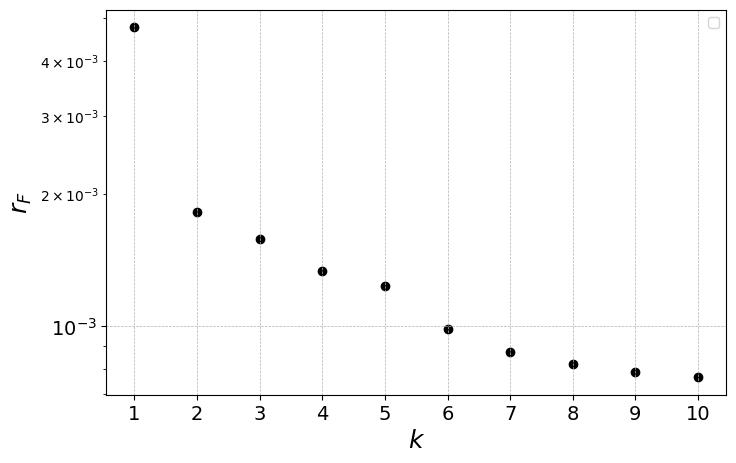

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = False
res = reg_result
all_lambdas = res.all_lambdas
print(all_lambdas)
all_xis = res.all_xis
xi_values = res.xi
sublibrary_terms = [term for i, term in enumerate(lib1.terms) if i in opts['scaler'].sub_inds]
equations = []
#print(eqs[i].coeffs)
#equation_terms = [f"{xi:.1e} {term}" for xi, term in zip(xi_values, sublibrary_terms) if abs(xi) > 1e-15]
#equation_string = " + ".join(equation_terms)
equation_string = str(eqn.pstr(**{'num_format': '{0:.3g}', 'latex_output': False}))
print(equation_string)
for xi in all_xis:
   print([f"{c:.1e} {term}" for c, term in zip(xi, sublibrary_terms) if abs(c) > 1e-15])

plt.figure(figsize=(8, 5))
#plt.scatter(range(2, len(all_lambdas) + 1), all_lambdas[1:], color='k')#, label="Lambda values") # range(1, 
plt.scatter(range(1, len(all_lambdas) + 1), all_lambdas, color='k')#, label="Lambda values")


# Set log scale for y-axis
plt.yscale("log")

fs = 18
fs2 = 14
plt.xlabel("$k$", fontsize=fs)
plt.ylabel("$r_F$", fontsize=fs)
#plt.title(f"Equation: {equation_string}")  # Use the computed equation as the title
#plt.xticks(range(2, len(all_lambdas) + 1), fontsize=fs2)  # Ensure x-axis ticks match the number of equations
plt.xticks(range(1, len(all_lambdas) + 1), fontsize=fs2)  # Ensure x-axis ticks match the number of equations

plt.yticks(fontsize=fs2)
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5) # which="both"
        

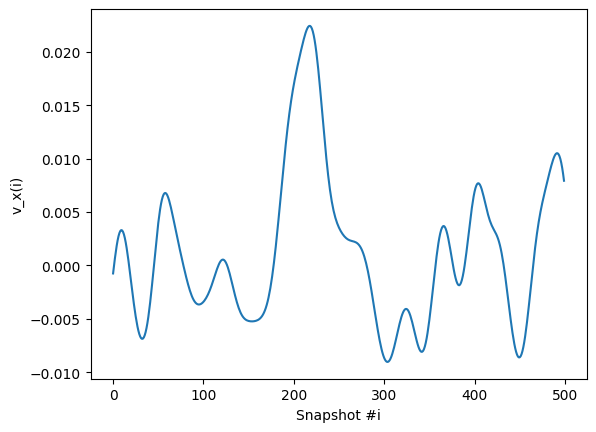

In [ ]:
plt.plot(vs[1, 0, :500])
plt.xlabel('Snapshot #i')
plt.ylabel('v_x(i)')
#plt.title('vs[0, 0, :] vs Time')
plt.show()

In [9]:
# Create a movie showing LibraryPrime values across the spatiotemporal dataset
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from PySPIDER.commons.library import Observable, DerivativeOrder, LibraryPrime
from PySPIDER.commons.process_library_terms import IntegrationDomain
from PySPIDER.commons.z3base import LiteralIndex
from PySPIDER.discrete.library import CoarseGrainedProduct

def prime_to_field_data(srd, prime, component_indices=None, domain_size=None, domain_offset=(0, 0, 0)):
    """
    Core function to convert a LibraryPrime to field data for plotting.
    
    Parameters:
    - srd: SRDataset instance
    - prime: LibraryPrime to evaluate
    - component_indices: For vector/tensor primes, which component to extract (e.g., (0,) for x-component)
    - domain_size: Domain size for evaluation. If None, uses srd.world_size
    - domain_offset: Domain offset
    
    Returns:
    - plot_data: numpy array of field data ready for plotting
    - component_label: string describing which component was selected
    - indexed_prime: the LibraryPrime that was actually evaluated
    """
    
    # Use world_size if domain_size not specified
    if domain_size is None:
        domain_size = tuple(int(s) for s in srd.world_size)
    
    print(f"Evaluating LibraryPrime: {prime} (rank {prime.rank})")
    print(f"Domain size: {domain_size}, offset: {domain_offset}")
    
    # Create the integration domain
    min_corner = [domain_offset[0], domain_offset[1], domain_offset[2]]
    max_corner = [min_corner[0] + domain_size[0] - 1, 
                 min_corner[1] + domain_size[1] - 1, 
                 min_corner[2] + domain_size[2] - 1]
    domain = IntegrationDomain(min_corner, max_corner)
    
    # Handle different ranks by creating properly indexed LibraryPrime
    if prime.rank == 0:
        # Scalar field - use as is
        indexed_prime = prime
        component_label = ""
    elif prime.rank >= 1:
        # Vector/tensor field - need to create indexed version
        if component_indices is None:
            # Default to first component
            if prime.rank == 1:
                component_indices = (0,)  # x-component
                component_label = " (x-component)"
            elif prime.rank == 2:
                component_indices = (0, 0)  # xx-component  
                component_label = " (xx-component)"
            else:
                component_indices = tuple([0] * prime.rank)
                component_label = f" (component {component_indices})"
        else:
            component_label = f" (component {component_indices})"
            
        print(f"Creating indexed version for component {component_indices}")
        
        # Create new observables with proper LiteralIndices
        indexed_observables = []
        for obs in prime.derivand.observables:
            # Create new observable with LiteralIndices based on component_indices
            literal_indices = tuple(LiteralIndex(component_indices[i % len(component_indices)]) 
                                   for i in range(obs.rank))
            indexed_obs = Observable(string=obs.string, rank=obs.rank, indices=literal_indices)
            indexed_observables.append(indexed_obs)
        
        # Create new CoarseGrainedProduct and LibraryPrime with indexed observables
        indexed_cgp = CoarseGrainedProduct(observables=tuple(indexed_observables))
        indexed_prime = LibraryPrime(derivative=prime.derivative, derivand=indexed_cgp)
        print(f"Indexed prime: {indexed_prime}")
    
    # Evaluate the indexed prime over the domain
    print("Evaluating over domain...")
    plot_data = srd.eval_prime(indexed_prime, domain, experimental=True, order=4)
    
    print(f"Field shape: {plot_data.shape}")
    print(f"Field range: [{np.min(plot_data):.3f}, {np.max(plot_data):.3f}]")
    print(f"Field mean: {np.mean(plot_data):.3f}, std: {np.std(plot_data):.3f}")
    
    return plot_data, component_label, indexed_prime

def create_libprime_movie(srd, prime_to_plot, domain_size=None, domain_offset=(0, 0, 0), 
                         output_path="discrete/libprime_movie.mp4", fps=10, title_suffix="", 
                         component_indices=None):
    """
    Create a movie showing the values of a specified LibraryPrime across the spatiotemporal dataset.
    
    Parameters:
    - srd: SRDataset instance
    - prime_to_plot: LibraryPrime to evaluate and plot
    - domain_size: Size of the domain to evaluate (x, y, t). If None, uses srd.world_size
    - domain_offset: Offset of the domain from origin
    - output_path: Path to save the movie
    - fps: Frames per second for the movie
    - title_suffix: Additional text for the plot title
    - component_indices: For rank>=1 fields, which component to plot (e.g., (0,) for x-component)
    """
    
    print(f"Creating movie for LibraryPrime: {prime_to_plot}")
    
    # Use central function to get field data
    plot_data, component_label, indexed_prime = prime_to_field_data(
        srd, prime_to_plot, component_indices, domain_size, domain_offset
    )
    
    n_times = plot_data.shape[-1]
    domain_size = tuple(int(s) for s in srd.world_size) if domain_size is None else domain_size
    
    # Set up the figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Find global min/max for consistent color scaling
    vmin = np.min(plot_data)
    vmax = np.max(plot_data)
    
    # Use a diverging colormap if the data spans both positive and negative values
    if vmin < 0 and vmax > 0:
        # Center the colormap at zero
        vmax_abs = max(abs(vmin), abs(vmax))
        vmin, vmax = -vmax_abs, vmax_abs
        cmap = 'RdBu_r'
    else:
        cmap = 'viridis'
    
    # Initialize the plot
    im = ax.imshow(plot_data[:, :, 0].T, origin='lower', vmin=vmin, vmax=vmax, 
                   cmap=cmap, extent=[domain_offset[0], domain_offset[0] + domain_size[0],
                                   domain_offset[1], domain_offset[1] + domain_size[1]])
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label(f'{prime_to_plot}{component_label}', fontsize=12)
    
    # Set labels and title
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.set_title(f'{prime_to_plot}{component_label}{title_suffix}', fontsize=14)
    
    # Time text
    time_text = ax.text(0.02, 0.98, f'Time step: 0', transform=ax.transAxes, 
                       fontsize=12, verticalalignment='top', 
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    def animate(frame):
        im.set_array(plot_data[:, :, frame].T)
        time_text.set_text(f'Time step: {frame}')
        return [im, time_text]
    
    # Create animation
    anim = animation.FuncAnimation(fig, animate, frames=n_times, interval=1000//fps, blit=True)
    
    # Set up ffmpeg path (adjust if needed)
    plt.rcParams['animation.ffmpeg_path'] = '/Users/daniel/Documents/ffmpeg-7.1/ffmpeg'
    
    # Save the movie
    print(f"Saving movie to {output_path}...")
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=fps, metadata=dict(artist='SPIDER'), bitrate=1800)
    anim.save(output_path, writer=writer)
    
    plt.close()
    print(f"Movie saved successfully!")
    
    return plot_data

# Create some example LibraryPrime terms to visualize
def create_example_primes():
    """Create some interesting LibraryPrime terms for visualization"""
    
    # Create pre-indexed observables to avoid runtime indexing issues
    v_x = Observable(string='v', rank=1, indices=(LiteralIndex(0),))  # x-component
    v_y = Observable(string='v', rank=1, indices=(LiteralIndex(1),))  # y-component
    
    # Create LibraryPrime terms (all result in scalar fields)
    # 1. Density (ρ) - scalar
    prime_rho = LibraryPrime(
        derivative=DerivativeOrder.blank_derivative(0, 0), 
        derivand=CoarseGrainedProduct(observables=())
    )
    
    # 2. x-momentum density (ρ[v_x]) - scalar
    prime_momentum_x = LibraryPrime(
        derivative=DerivativeOrder.blank_derivative(0, 0), 
        derivand=CoarseGrainedProduct(observables=(v_x,))
    )
    
    # 3. y-momentum density (ρ[v_y]) - scalar  
    prime_momentum_y = LibraryPrime(
        derivative=DerivativeOrder.blank_derivative(0, 0), 
        derivand=CoarseGrainedProduct(observables=(v_y,))
    )
    
    # 4. Kinetic energy density (ρ[v_x·v_x]) - scalar
    prime_kinetic = LibraryPrime(
        derivative=DerivativeOrder.blank_derivative(0, 0), 
        derivand=CoarseGrainedProduct(observables=(v_x, v_x))
    )
    
    return {
        'density': prime_rho,
        'momentum_x': prime_momentum_x,
        'momentum_y': prime_momentum_y, 
        'kinetic_energy': prime_kinetic
    }

# Example usage - create movies for different LibraryPrime terms
print("Creating example LibraryPrime terms...")
example_primes = create_example_primes()
print(example_primes)

# Choose which prime to plot (you can change this)
prime_name = 'momentum_x'  # Options: 'density', 'momentum_x', 'momentum_y', 'kinetic_energy'
prime_to_plot = example_primes[prime_name]

print(f"Selected prime for visualization: {prime_name} -> {prime_to_plot}")

# Create the movie using the entire dataset (world_size domain)
field_data = create_libprime_movie(
    srd=srd, 
    prime_to_plot=prime_to_plot,
    domain_size=None,  # Use full world_size
    domain_offset=(0, 0, 0),  # Start from origin
    output_path=f"libprime_{prime_name}_movie.mp4",
    fps=15,
    title_suffix=f" - {prime_name.replace('_', ' ').title()}"
)

Creating example LibraryPrime terms...
{'density': ρ, 'momentum_x': ρ[v_x], 'momentum_y': ρ[v_y], 'kinetic_energy': ρ[v_x · v_x]}
Selected prime for visualization: momentum_x -> ρ[v_x]
Creating movie for LibraryPrime: ρ[v_x]
Evaluating LibraryPrime: ρ[v_x] (rank 0)
Domain size: (248, 248, 1000), offset: (0, 0, 0)
Evaluating over domain...


KeyError: 'v'

In [8]:
# Interactive exploration of existing LibraryPrime terms from the libraries
def explore_library_primes(srd, irrep_rank=0, max_terms_to_show=20):
    """
    Explore and visualize LibraryPrime terms from the existing libraries.
    
    Parameters:
    - srd: SRDataset instance with libraries already created
    - irrep_rank: Which irrep rank to explore (0 for scalars, 1 for vectors, etc.)
    - max_terms_to_show: Maximum number of terms to display
    """
    
    if not hasattr(srd, 'libs') or irrep_rank not in srd.libs:
        print(f"No library found for irrep rank {irrep_rank}")
        print(f"Available irreps: {list(srd.libs.keys()) if hasattr(srd, 'libs') else 'None'}")
        return
    
    lib = srd.libs[irrep_rank]
    print(f"Library for irrep rank {irrep_rank} contains {len(lib.terms)} terms")
    
    # Extract all unique primes from the library terms
    all_primes = set()
    for term in lib.terms[:max_terms_to_show]:
        for prime in term.primes:
            all_primes.add(prime)
    
    all_primes = sorted(list(all_primes))
    print(f"Found {len(all_primes)} unique LibraryPrime terms")
    
    # Display the primes with indices
    print("\nAvailable LibraryPrime terms:")
    for i, prime in enumerate(all_primes):
        print(f"  {i:2d}: {prime}")
    
    return all_primes

def plot_library_prime_by_index(srd, all_primes, prime_index, domain_size=None, domain_offset=(0, 0, 0), component_indices=None):
    """
    Plot a specific LibraryPrime by its index in the list.
    """
    
    if prime_index >= len(all_primes):
        print(f"Index {prime_index} out of range. Available indices: 0-{len(all_primes)-1}")
        return
    
    prime_to_plot = all_primes[prime_index]
    print(f"Plotting LibraryPrime {prime_index}: {prime_to_plot}")
    
    # Create the movie
    try:
        field_data = create_libprime_movie(
            srd=srd,
            prime_to_plot=prime_to_plot,
            domain_size=domain_size,
            domain_offset=domain_offset,
            output_path=f"discrete/libprime_index_{prime_index}_movie.mp4",
            fps=12,
            title_suffix=f" - Index {prime_index}",
            component_indices=component_indices
        )
        
        # Show a static frame for quick preview
        fig, ax = plt.subplots(figsize=(8, 6))
        mid_time = field_data.shape[-1] // 2
        
        vmin, vmax = np.min(field_data), np.max(field_data)
        if vmin < 0 and vmax > 0:
            vmax_abs = max(abs(vmin), abs(vmax))
            vmin, vmax = -vmax_abs, vmax_abs
            cmap = 'RdBu_r'
        else:
            cmap = 'viridis'
        
        im = ax.imshow(field_data[:, :, mid_time].T, origin='lower', vmin=vmin, vmax=vmax, 
                       cmap=cmap, extent=[domain_offset[0], domain_offset[0] + domain_size[0],
                                       domain_offset[1], domain_offset[1] + domain_size[1]])
        
        plt.colorbar(im, ax=ax, shrink=0.8)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f'{prime_to_plot} - Frame {mid_time}')
        plt.tight_layout()
        plt.show()
        
        return field_data
        
    except Exception as e:
        print(f"Error plotting prime {prime_index}: {e}")
        return None

# Explore the available primes
print("Exploring available LibraryPrime terms in the libraries...")
available_primes = explore_library_primes(srd, irrep_rank=0, max_terms_to_show=15)

if available_primes:
    print(f"\nTo plot a specific prime, use:")
    print(f"plot_library_prime_by_index(srd, available_primes, INDEX)")
    print(f"where INDEX is a number from 0 to {len(available_primes)-1}")
    
    # Example: Plot the first few interesting primes
    interesting_indices = [0, 1, 2, 3] if len(available_primes) > 3 else list(range(len(available_primes)))
    
    print(f"\nExample: Plotting prime at index 0...")
    if len(available_primes) > 0:
        field_data = plot_library_prime_by_index(srd, available_primes, 0, 
                                                domain_size=None,  # Use full world_size
                                                domain_offset=(0, 0, 0))  # Start from origin


Exploring available LibraryPrime terms in the libraries...
No library found for irrep rank 0
Available irreps: [Rank 0, Rank 1, Antisymmetric rank 2, Symmetric trace-free rank 2]


In [10]:
# CORRECTED: Multi-prime comparison using the central prime_to_field_data function
def create_multi_prime_comparison_movie(srd, primes_to_compare, prime_names=None, 
                                           domain_size=None, domain_offset=(0, 0, 0),
                                           output_path="discrete/multi_prime_comparison_v2.mp4", fps=10, 
                                           component_indices_list=None):
    """
    Create a movie comparing multiple LibraryPrime terms side by side.
    UPDATED to use the central prime_to_field_data function.
    
    Parameters:
    - srd: SRDataset instance
    - primes_to_compare: List of LibraryPrime objects to compare
    - prime_names: List of names for the primes (optional)
    - domain_size: Size of the domain to evaluate. If None, uses srd.world_size
    - domain_offset: Offset of the domain from origin
    - output_path: Path to save the movie
    - fps: Frames per second
    - component_indices_list: List of component indices for each prime (for rank>=1 fields)
    """
    
    n_primes = len(primes_to_compare)
    if n_primes == 0:
        print("No primes provided for comparison")
        return
    
    if prime_names is None:
        prime_names = [f"Prime {i}: {prime}" for i, prime in enumerate(primes_to_compare)]
    
    # Use world_size if domain_size not specified
    if domain_size is None:
        domain_size = tuple(int(s) for s in srd.world_size)
    
    # Set default component indices if not provided
    if component_indices_list is None:
        component_indices_list = [None] * n_primes
    
    print(f"Comparing {n_primes} LibraryPrime terms...")
    print(f"Domain size: {domain_size}, offset: {domain_offset}")
    
    # Evaluate all primes using the central function
    field_data_list = []
    component_labels = []
    
    for i, prime in enumerate(primes_to_compare):
        print(f"\n--- Prime {i+1}/{n_primes} ---")
        component_indices = component_indices_list[i]
        
        # Use central function to get field data
        plot_data, component_label, indexed_prime = prime_to_field_data(
            srd, prime, component_indices, domain_size, domain_offset
        )
        
        field_data_list.append(plot_data)
        component_labels.append(component_label)
    
    n_times = field_data_list[0].shape[-1]
    
    # Set up the figure with subplots
    cols = min(n_primes, 3)  # Maximum 3 columns
    rows = (n_primes + cols - 1) // cols  # Ceiling division
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    if n_primes == 1:
        axes = [axes]
    elif rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()
    
    # Initialize plots
    ims = []
    
    for i in range(n_primes):
        ax = axes[i]
        field_data = field_data_list[i]
        component_label = component_labels[i]
        
        # Determine colormap and scaling
        vmin, vmax = np.min(field_data), np.max(field_data)
        if vmin < 0 and vmax > 0:
            vmax_abs = max(abs(vmin), abs(vmax))
            vmin, vmax = -vmax_abs, vmax_abs
            cmap = 'RdBu_r'
        else:
            cmap = 'viridis'
        
        # Create image
        im = ax.imshow(field_data[:, :, 0].T, origin='lower', vmin=vmin, vmax=vmax, 
                      cmap=cmap, extent=[domain_offset[0], domain_offset[0] + domain_size[0],
                                       domain_offset[1], domain_offset[1] + domain_size[1]])
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, shrink=0.8)
        cbar.set_label(f'{primes_to_compare[i]}{component_label}', fontsize=10)
        
        # Set labels and title
        ax.set_xlabel('x', fontsize=10)
        ax.set_ylabel('y', fontsize=10)
        ax.set_title(f'{prime_names[i]}{component_label}', fontsize=11)
        
        ims.append(im)
    
    # Hide unused subplots
    for i in range(n_primes, len(axes)):
        axes[i].set_visible(False)
    
    # Add overall time text
    time_text = fig.suptitle(f'Time step: 0', fontsize=14)
    
    def animate(frame):
        for i in range(n_primes):
            ims[i].set_array(field_data_list[i][:, :, frame].T)
        time_text.set_text(f'Time step: {frame}')
        return ims + [time_text]
    
    # Create animation
    anim = animation.FuncAnimation(fig, animate, frames=n_times, interval=1000//fps, blit=True)
    
    # Set up ffmpeg path
    plt.rcParams['animation.ffmpeg_path'] = '/Users/daniel/Documents/ffmpeg-7.1/ffmpeg'
    
    # Save the movie
    print(f"Saving comparison movie to {output_path}...")
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=fps, metadata=dict(artist='SPIDER'), bitrate=2400)
    anim.save(output_path, writer=writer)
    
    plt.close()
    print(f"Comparison movie saved successfully!")
    
    return field_data_list

# Updated demo function using pre-indexed observables
def demo_multi_prime_comparison(srd):
    """
    Demonstrate multi-prime comparison with properly indexed combinations.
    UPDATED to use pre-indexed observables and the central function.
    """
    
    print("Creating demonstration of multi-prime comparison (v2)...")
    
    # Create properly indexed primes for comparison (all scalar, no indexing issues)
    vbar_x = Observable(string='vbar', rank=1, indices=(LiteralIndex(0),))
    vprime_x = Observable(string='v\'', rank=1, indices=(LiteralIndex(0),))
    
    # Different types of terms (all result in scalar fields)
    primes_to_compare = [
        # Density (scalar)
        LibraryPrime(derivative=DerivativeOrder.blank_derivative(0, 0), 
                    derivand=CoarseGrainedProduct(observables=())),
        
        # x-momentum density (scalar)
        LibraryPrime(derivative=DerivativeOrder.blank_derivative(0, 0), 
                    derivand=CoarseGrainedProduct(observables=(vbar_x,))),
        
        # y-momentum density (scalar)
        LibraryPrime(derivative=DerivativeOrder.blank_derivative(0, 0), 
                    derivand=CoarseGrainedProduct(observables=(vprime_x,))),
    ]
    
    prime_names = [
        "Density (ρ)",
        "Averaged x-Momentum (ρ[vbar_x])",  
        "Deviation of x-Momentum (ρ[v\'_x])"
    ]
    
    try:
        field_data_list = create_multi_prime_comparison_movie(
            srd=srd,
            primes_to_compare=primes_to_compare,
            prime_names=prime_names,
            domain_size=None,  # Use full world_size
            domain_offset=(0, 0, 0),  # Start from origin
            output_path="demo_multi_prime_comparison_v2.mp4",
            fps=12
        )
        
    except Exception as e:
        print(f"Error in demonstration: {e}")
        import traceback
        traceback.print_exc()

# Run the updated demonstration
print("Running multi-prime comparison demonstration (v2)...")
demo_multi_prime_comparison(srd)


Running multi-prime comparison demonstration (v2)...
Creating demonstration of multi-prime comparison (v2)...
Comparing 3 LibraryPrime terms...
Domain size: (248, 248, 1000), offset: (0, 0, 0)

--- Prime 1/3 ---
Evaluating LibraryPrime: ρ (rank 0)
Domain size: (248, 248, 1000), offset: (0, 0, 0)
Evaluating over domain...
Field shape: (248, 248, 1000)
Field range: [0.000, 2.701]
Field mean: 1.000, std: 0.703

--- Prime 2/3 ---
Evaluating LibraryPrime: ρ[vbar_x] (rank 0)
Domain size: (248, 248, 1000), offset: (0, 0, 0)
Evaluating over domain...
Field shape: (248, 248, 1000)
Field range: [-0.020, 0.020]
Field mean: -0.000, std: 0.003

--- Prime 3/3 ---
Evaluating LibraryPrime: ρ[v'_x] (rank 0)
Domain size: (248, 248, 1000), offset: (0, 0, 0)
Evaluating over domain...
Field shape: (248, 248, 1000)
Field range: [-0.017, 0.017]
Field mean: 0.000, std: 0.002
Saving comparison movie to demo_multi_prime_comparison_v2.mp4...
Comparison movie saved successfully!
